# Forest Fire Modeling and Analysis

Forest fires are a major enviromental issue worldwide and particularly in the American West. The damage they cause is both ecological and economical, and the severity and frequency of these fires seems to be increasing as our efforts to curb man-made climate change have fallen short. These increased costs are dramatic. The United States Forest Service now spends around $2 billion a year in attempts to manage forest fires - a 600% increase from 2 decades ago. 

Fast detection of forest fires can play a key role in minimizing the damage caused by them. Previously this has been done by humans in fire lookout towers, but their role has been reduced by the use of supplemental technology, with varying results. Unmanned drones brought promise of safe and easy fire detection, but also brought with them prohibitive costs of operation. In certain environments, high-tech cameras have trouble accurately detecting smoke. It is clear that innovative solutions are needed to help manage forest fires.

We will build an automated system that can be fed known data, such as that being routinely collected by a meteorological station, and predict a fire's size. This is useful because not all fires necessarily need to be put out, and if accurate the model could direct fire management services to areas that require the most attention.

The [dataset](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) we are using contains meteorological data from a region in northeast Portugal. The selection of this data is merely for simplicity - it has already been collected and distributed for free by UCI's machine learning repository. However with our insights from this model we believe we can make a similiar model applicable to another region, such as Northern California, Oregon, or Washington.

## Imports

In [65]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import neighbors
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

# Read in our data
fires_df = pd.read_csv('https://raw.githubusercontent.com/mas1/forest-fire-modeling/master/forestfires.csv')

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_rows = 300

## Exploratory Data Analysis

In [3]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


The data appears to be pretty clean. This is expected based on the description provided by UCI. I will drop month and day. We don't want a model that uses month to predict forest fire damage. We instead want the model predicting off of meterological features and information from the Fire Weather Index (FWI). X and Y will be dropped, as these are location features specific to Portugal. This location data would certainly be useful within context, however not for the purposes of our project.

In [4]:
fires_df.drop(columns=['X', 'Y', 'day'], inplace=True)
fires_df2 = fires_df.copy()

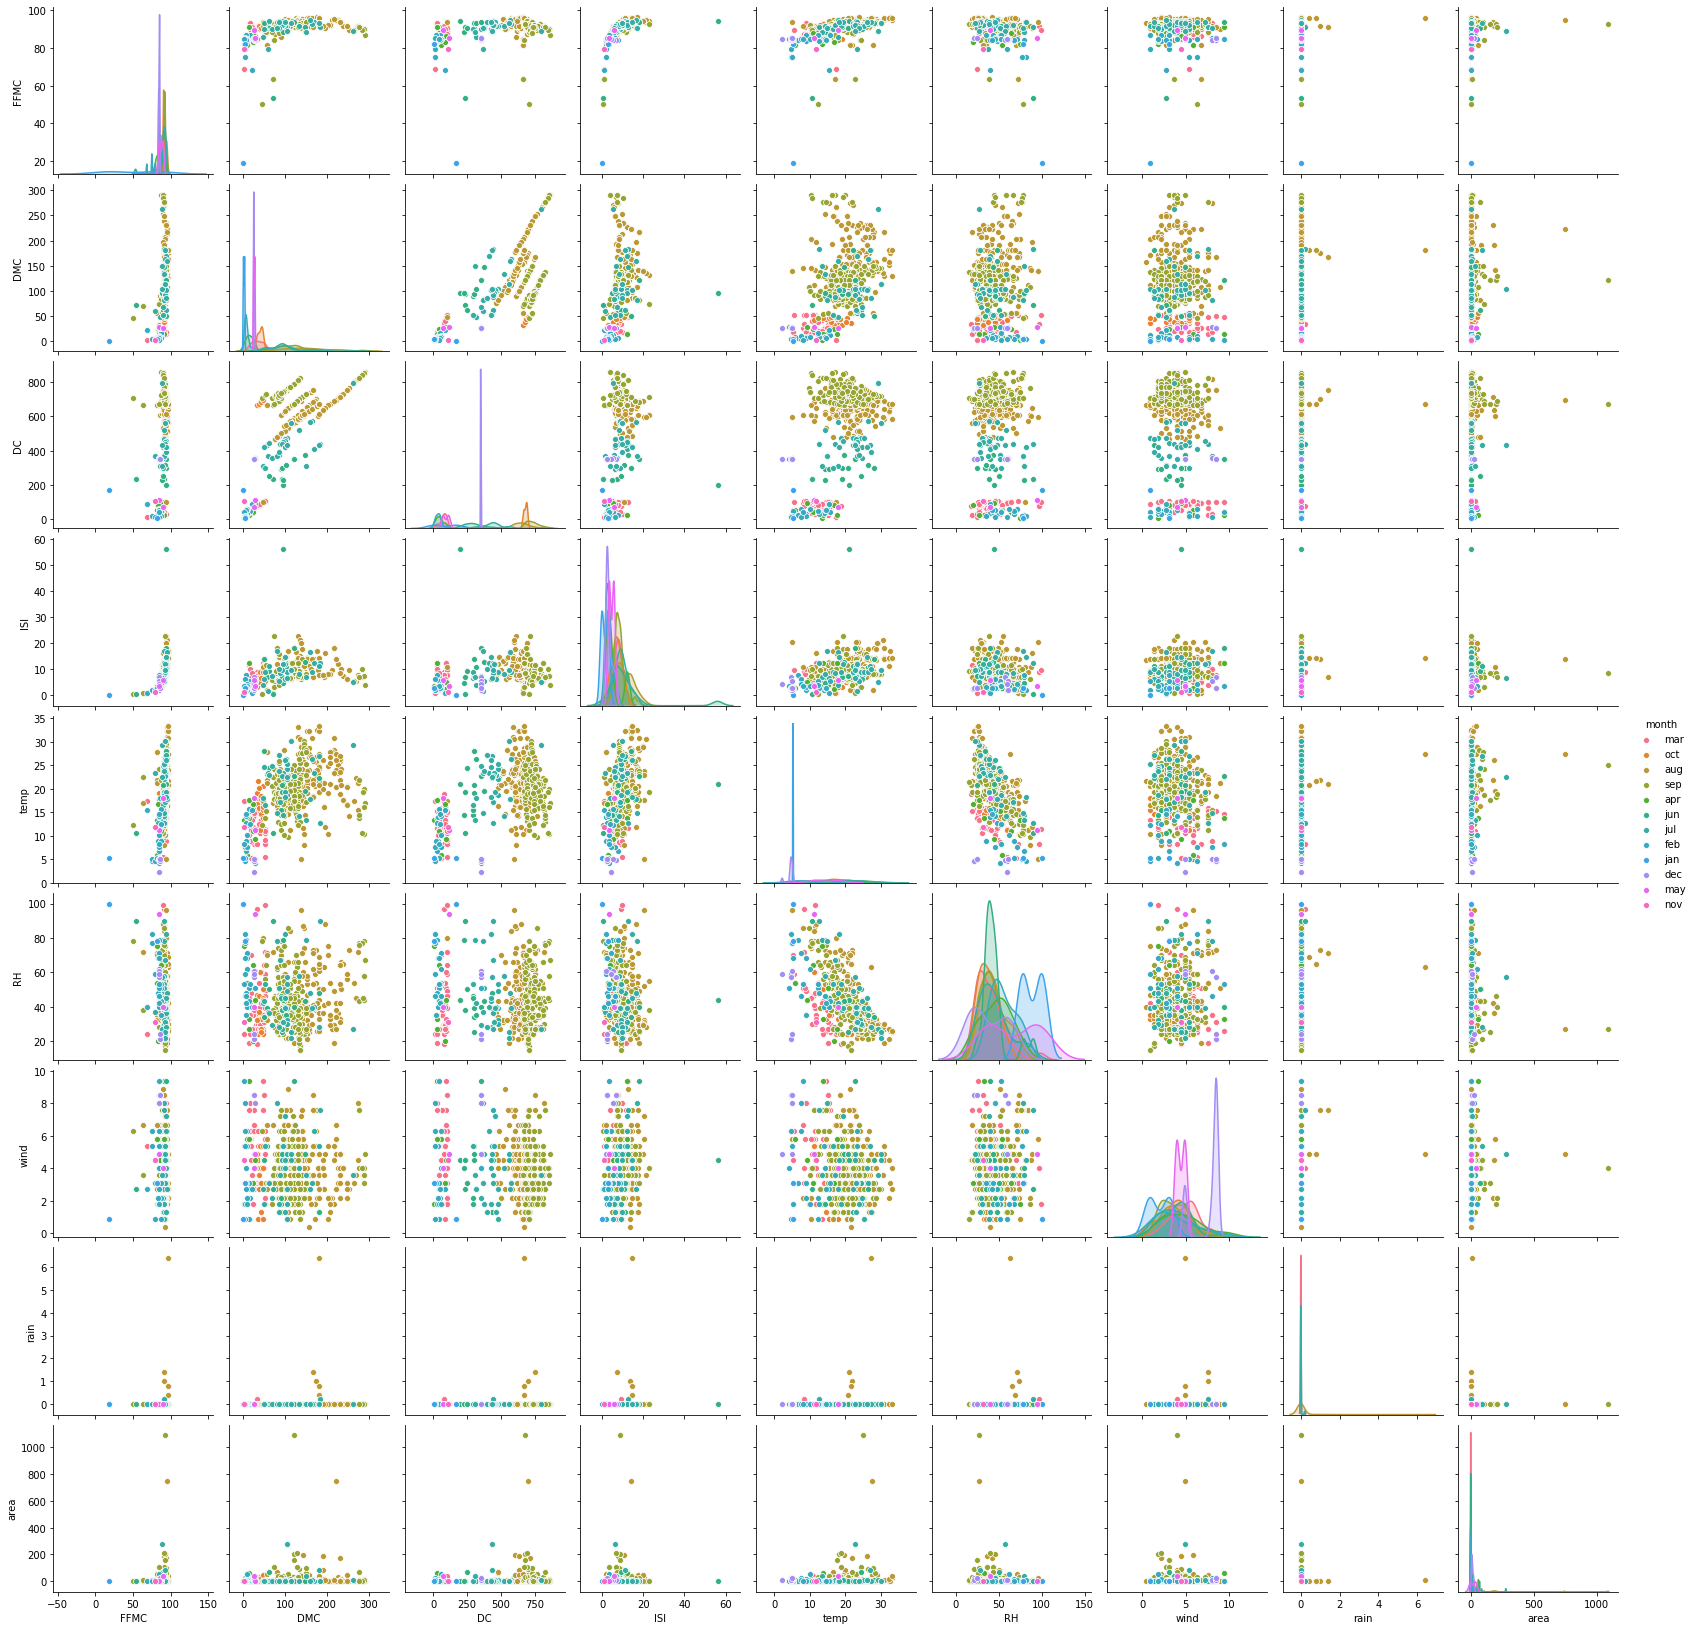

In [5]:
pairplot = sns.pairplot(fires_df2, hue='month')

The first thing I notice are the two huge outliers in the area field. Let's drop these. 

In [6]:
fires_df2.sort_values(['area']).tail(5)

,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
236,sep,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
237,sep,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
479,jul,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53
415,aug,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
238,sep,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84


In [7]:
fires_df2 = fires_df2[fires_df2['area'] < 300]

In [8]:
def classifier(row):
  if row['area'] < 1:
    return 'small'
  elif row['area'] >= 1 and row['area'] < 5:
    return 'medium'
  else:
    return 'large'


In [9]:
fires_df2['burn_area'] = fires_df2.apply(classifier, axis=1)

In [10]:
#if we decide to go back and do single classifier
#fires_df2[fires_df2['area'] > 5].shape
#fires_df2['large_fire'] = fires_df2['area'] > 1
#fires_df2['large_fire'] = fires_df2['large_fire'].astype(int)

In [11]:
fires_df2['burn_area'].value_counts()

small     274
large     149
medium     92
Name: burn_area, dtype: int64

Some of our variables approach normality, but others don't. I am going to apply both a boxcox and a log transform to see if I can make them conform to normality.

In [12]:
num_cols = fires_df2.drop(columns=['month', 'burn_area']).columns

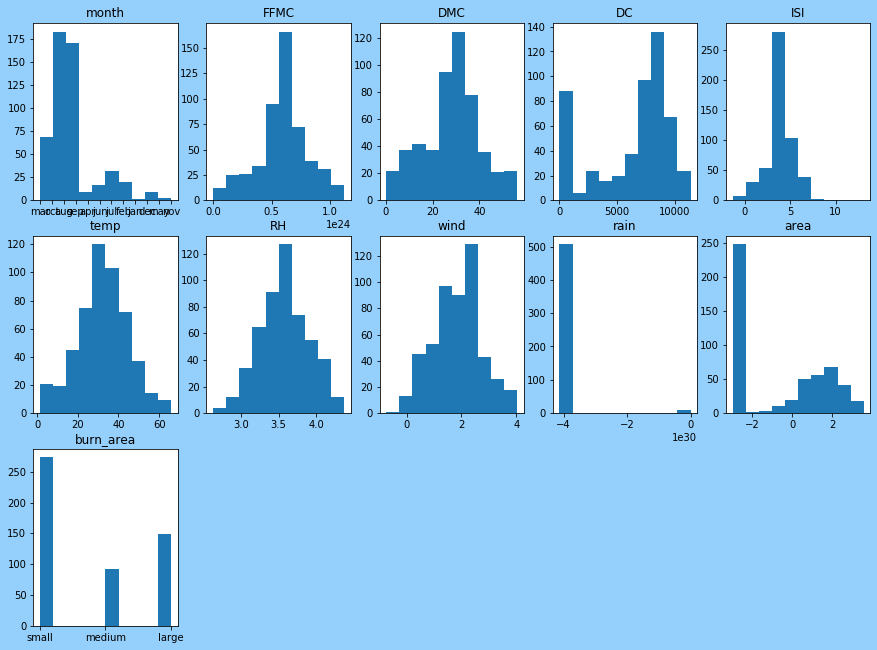

In [13]:
i = 1
fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('xkcd:light blue')

fires_boxcox = fires_df2.copy()

# replace 0s so boxcox transform works
for col in num_cols:
  fires_boxcox[col] = fires_boxcox[col].astype('float')
  fires_boxcox[col] = fires_boxcox[col].replace(0, 0.1)
  fires_boxcox[col],_ = boxcox(fires_boxcox[col])

# plot boxcox transform
for col in fires_df2.columns:
  plt.subplot(4, 5, i)
  i += 1
  plt.hist(fires_boxcox[col])
  plt.title(col)
  
plt.show()


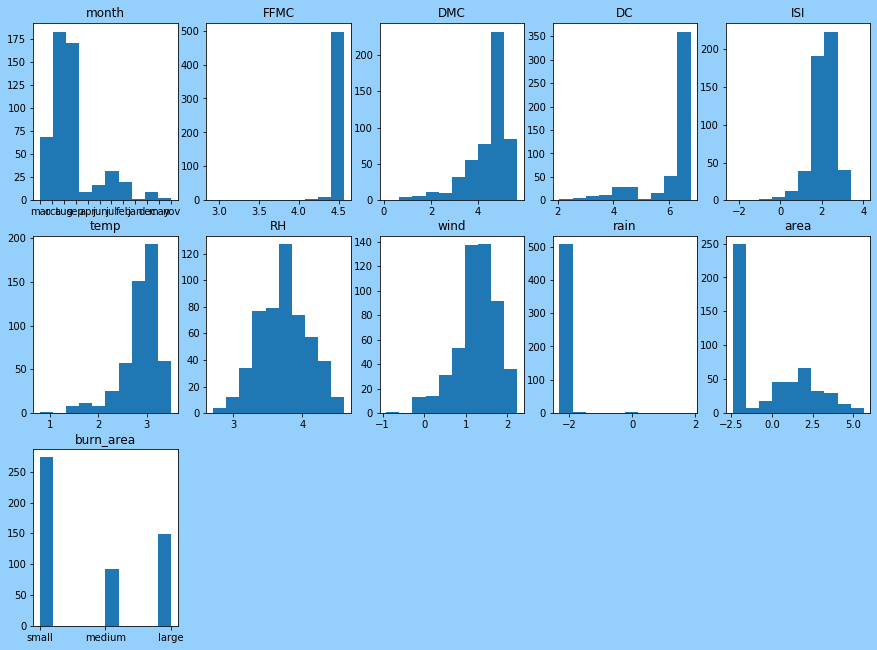

In [14]:
i=1
fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('xkcd:light blue')

fires_logged = fires_df2.copy()

# replace 0s with .1 to aid with log transform process
for col in num_cols:
  fires_logged[col] = fires_logged[col].astype('float')
  fires_logged[col] = fires_logged[col].replace(0, 0.1)
  fires_logged[col] = np.log(fires_logged[col])

# display log transformed histograms
for col in fires_df2.columns:
  plt.subplot(4, 5, i)
  i += 1
  plt.hist(fires_logged[col])
  plt.title(col)
  
plt.show()


Let's look at correlation. We want to pay particular attention to our independent variables to avoid multicolinearity. 

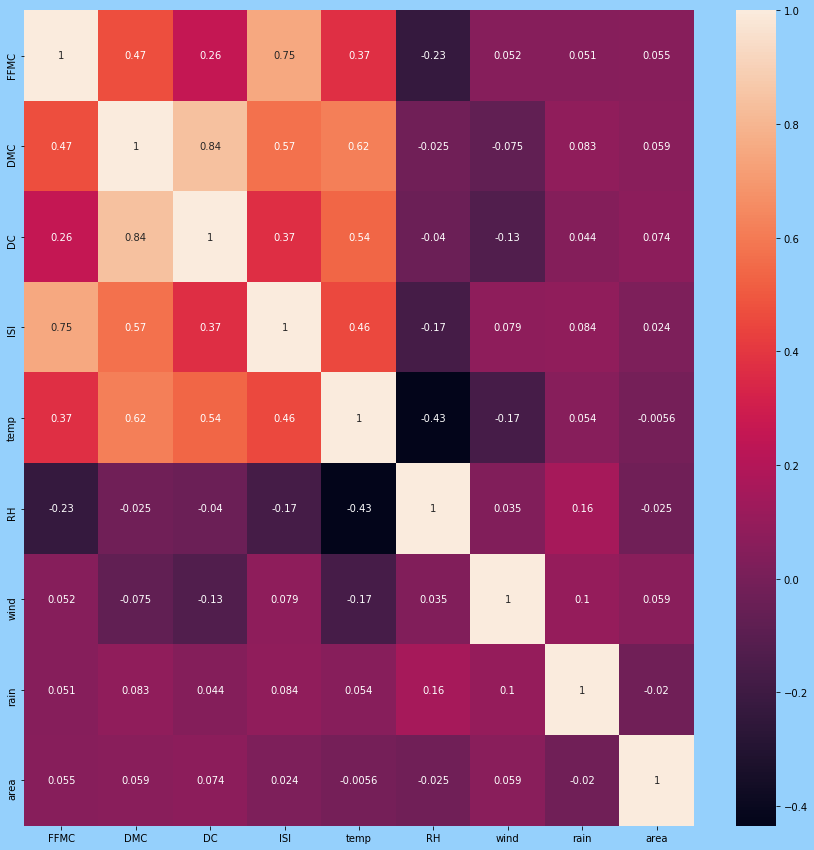

In [15]:
fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('xkcd:light blue')
sns.heatmap(fires_logged.corr(method='pearson'), annot=True)

We will make a train-test split with a 15% test size. 




In [16]:
#y_preds = model.predict(X_test)
#fig = plt.figure()
#fig.patch.set_facecolor('xkcd:light blue')
#plt.scatter(y_test, y_preds)
#plt.plot(y_test, y_test, color="red",)
#plt.xlabel("true values")
#plt.ylabel("predicted values")
#plt.title("area: true and predicted values")
#plt.show()

In [17]:
X = fires_logged.drop(columns=['area', 'month', 'burn_area', 'DMC', 'FFMC', 'ISI', 'DC'])
y = fires_logged['burn_area']

In [18]:
#X = fires_df2.drop(columns=['area', 'month', 'burn_area', 'DMC', 'FFMC', 'ISI'])
#y = fires_df2['burn_area']

In [19]:
#X = fires_boxcox.drop(columns=['area', 'rain', 'DMC', 'month', 'FFMC', 'burn_area'])
#y = fires_boxcox['burn_area']

## KNN

We are going to setup a pipeline for our KNN model. This model will likely not be the most accurate but will give a good baseline. It is also a very fast model, so I will use it to test the pipeline process and feature set that I will use on the other models.

In [40]:
#num_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

num_cols = ['temp', 'RH', 'wind', 'rain']
#cat_cols = []
#drop_cats = []
#bin_cols = [] if necessary

preprocessing = ColumnTransformer([
                                   # Encoding if necessary 
                                   #('OneHotEncoder', OneHotEncoder(drop=None), cat_cols),
                                   # Scale numeric cols (not needed for all models but can't hurt)
                                   ('scaler', StandardScaler(), num_cols)
                                   # bin_cols we'll leave untouched
], remainder='passthrough')

pipeline = Pipeline([
                     ('preprocessing', preprocessing),
                     # Choose your model and put it here
                     ('model', KNeighborsClassifier())
])

grid = {
    # Use model__ with hyperparammeter names after
    'model__n_neighbors':[17, 18, 19, 20],
    'model__weights':['uniform', 'distance'],
    'model__algorithm':['auto'],
    'model__leaf_size':[2, 3, 5, 10],
    'model__n_jobs':[1]
}

pipeline_knn = GridSearchCV(pipeline, grid)

scores = cross_val_score(pipeline_knn, X, y, cv=10)

print(scores.mean())

0.4949849170437406


In [41]:
pipeline_knn.fit(X, y)
pipeline_knn.best_params_

{'model__algorithm': 'auto',
 'model__leaf_size': 2,
 'model__n_jobs': 1,
 'model__n_neighbors': 19,
 'model__weights': 'uniform'}

In [68]:
y_true, y_pred = y, pipeline_knn.predict(X)
print(confusion_matrix(y_true, y_pred))

[[ 36   1 112]
 [ 11   4  77]
 [ 24   2 248]]


In [45]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

       large       0.51      0.24      0.33       149
      medium       0.57      0.04      0.08        92
       small       0.57      0.91      0.70       274

    accuracy                           0.56       515
   macro avg       0.55      0.40      0.37       515
weighted avg       0.55      0.56      0.48       515



## Random Forest

Based on the results of our KNN model, it seems the best feature set only uses the 4 meteorological inputs, wind, relative humidity, temperature, and rain. The log transformed dataset performed the best as well. 

Now we will set up a pipeline for a Random Forest model. I am expecting slightly better results. After this we will implement the most computationally expensive model, XGBoost.

In [61]:
pipeline = Pipeline([
                     ('preprocessing', preprocessing),
                     ('model', RandomForestClassifier())
])

grid = {
    'model__n_estimators':[70, 75],
    'model__criterion':['gini', 'entropy'],
    'model__max_depth':[2],
    'model__min_samples_leaf':[2],
    'model__max_features':['sqrt', 'log2'],
    'model__n_jobs':[1]
}

pipeline_rf = GridSearchCV(pipeline, grid)

scores = cross_val_score(pipeline_rf, X, y, cv=10)

print(scores.mean())

0.5358974358974359


After multiple iterations tuning the hyperparameters, we get our best results with these:

In [58]:
pipeline_rf.fit(X, y)
pipeline_rf.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__n_estimators': 70,
 'model__n_jobs': 1}

In [72]:
y_true, y_pred = y, pipeline_rf.predict(X)
print(confusion_matrix(y_true, y_pred))
print('\n')
print(classification_report(y_true, y_pred))

[[ 12   0 137]
 [  1   2  89]
 [  1   0 273]]


              precision    recall  f1-score   support

       large       0.86      0.08      0.15       149
      medium       1.00      0.02      0.04        92
       small       0.55      1.00      0.71       274

    accuracy                           0.56       515
   macro avg       0.80      0.37      0.30       515
weighted avg       0.72      0.56      0.43       515



## Gradient Boosting

In [69]:
pipeline = Pipeline([
                     ('preprocessing', preprocessing),
                     ('model', XGBClassifier())
])

grid = {
    'model__n_estimators':[70],
    'model__learning_rate':[.01, .02, .05,],
    'model__min_child_weight':[.5, 1, 1.5],
    'model__max_depth':[2, 3, 4],
    'model__gamma':[0, .005],
    'model__n_jobs':[-1]
}

pipeline_xgb = GridSearchCV(pipeline, grid)

scores = cross_val_score(pipeline_xgb, X, y, cv=10)

print(scores.mean())

0.5144042232277526


In [73]:
pipeline_xgb.fit(X, y)
pipeline_xgb.best_params_

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': 2,
 'model__min_child_weight': 0.5,
 'model__n_estimators': 70,
 'model__n_jobs': -1}

In [74]:
y_true, y_pred = y, pipeline_xgb.predict(X)
print(confusion_matrix(y_true, y_pred))
print('\n')
print(classification_report(y_true, y_pred))

[[ 12   0 137]
 [  1   3  88]
 [  1   0 273]]


              precision    recall  f1-score   support

       large       0.86      0.08      0.15       149
      medium       1.00      0.03      0.06        92
       small       0.55      1.00      0.71       274

    accuracy                           0.56       515
   macro avg       0.80      0.37      0.31       515
weighted avg       0.72      0.56      0.43       515



## Analysis

To be blunt, our models are not very good at predicting the size of forest fires..

Within the context of our problem, we would really like to minimize false negatives in the large fire classification. We would not want our model telling fire management teams that there was no danger of a large fire when in reality there is. With this in mind we want to maximize recall over other indicators. We can see that our recall for large fire classification is highest with our KNN model. Yet it is still too low too be of value.

Our Random Forest and XGBoost models do a very good job correctly classifying the smaller fires. Only one small fire was incorrectly classified. More analysis needs to be done to determine whether this is an actual function of the model or if it is simply caused by the class imbalance. 

If we assume our model is correctly classifying small fires, it could be implemented as some sort of 'low fire risk' indicator given meterological inputs of a given day.

With a larger dataset, and by addressing the class inbalance, we could likely improve our model.